# Dirichlet Process Mixture Model

This notebook implements a simple non-parametric Bayesian model called a 
[Dirichlet Process Mixture Model](https://en.wikipedia.org/wiki/Dirichlet_process)
using a stick-breaking formulation.


In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from flippy import flip, condition, mem, infer, keep_deterministic
from flippy.distributions import Beta, Normal, Gamma, Categorical

In [2]:
@mem
def break_stick(c, concentration=1.0):
    prob = Beta(1, concentration).sample()
    return prob

@mem
def category_params(c):
    return Normal(0, 5).sample(), (1/Gamma(1, 1).sample())**.5

def sample_category(c=None):
    c = c or 0
    if flip(break_stick(c)):
        return c, category_params(c)
    return sample_category(c + 1)

def category_dist(cs):
    max_c = max(cs)
    cdist = {c: (break_stick(c), category_params(c)) for c in range(max_c + 1)}
    return cdist

@infer(method="MetropolisHastings", samples=500, burn_in=1000, thinning=10, seed=52512)
def model(data):
    cs = ()
    for x in data:
        c, (mu, sd) = sample_category()
        Normal(mu, sd).observe(x)
        cs += (c,)
    return category_dist(cs)


In [3]:
dataset1 = (2.77, 2.85, 1.98, 1.67, 1.04, -0.4, -0.1, 6.8, 8.7, 6.0, 8.4, 6.0, 7.8, 7.3, 6.8, 6.5, 6.8)
dist = model(dataset1)

Text(0.5, 1.0, 'Cluster Count Distribution')

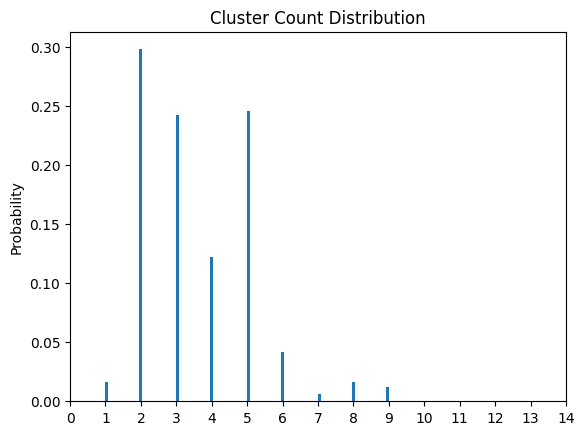

In [4]:
# cluster count distribution
ax = dist.marginalize(lambda cdist: len(cdist)).plot()
ax.set_xticks(np.arange(0, 15, 1))
ax.set_title("Cluster Count Distribution")

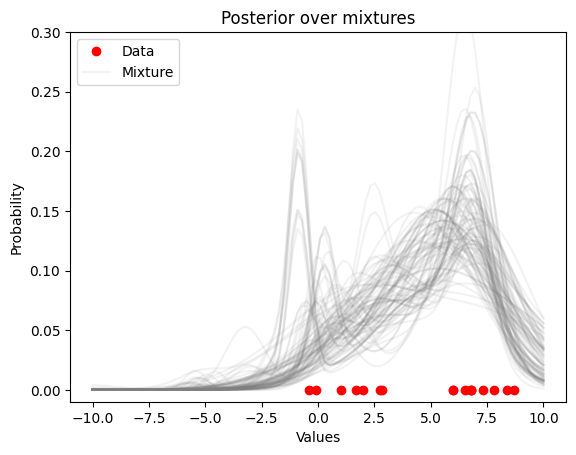

In [5]:
def plot_dp_mixture_sample(cdist, ax, **kws):
    cat_dist = {c: prob for c, (prob, _) in cdist.items()}
    for c, (prob, _) in cdist.items():
        for c_ in range(c + 1, max(cdist) + 1):
            cat_dist[c_] *= 1 - prob

    prob = np.zeros(100)
    for c, (_, (mu, sd)) in cdist.items():
        prob += stats.norm(mu, sd).pdf(np.linspace(-10, 10, 100)) * cat_dist[c]

    ax.plot(np.linspace(-10, 10, 100), prob, **kws)

def plot_posterior(data, dist):
    fig, ax = plt.subplots()
    ax.plot(data, [0] * len(data), "o", color="red", label='Data')
    for idx in range(100):
        cdist = dist.sample()
        plot_dp_mixture_sample(cdist, ax, alpha=.1, color="grey", label='Mixture' if idx == 0 else None)
    ax.set_title('Posterior over mixtures')
    ax.set_xlabel('Values')
    ax.set_ylabel('Probability')
    ax.set_ylim(-0.01, 0.3)
    ax.legend()

plot_posterior(dataset1, dist)

In [6]:
dataset2 = (2.0, 2.15, 1.98, 1.67, 1.54, -2.4, -2.1, 5.5, 6.8, 8.7, 6.0, 8.4, 9.1, 7.8, 7.3, 6.8, 6.5, 6.8)
dist = model(dataset2)

Text(0.5, 1.0, 'Cluster Count Distribution')

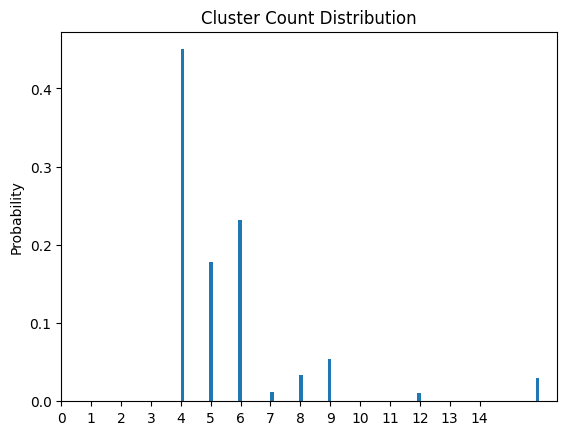

In [7]:
ax = dist.marginalize(lambda cdist: len(cdist)).plot()
ax.set_xticks(np.arange(0, 15, 1))
ax.set_title("Cluster Count Distribution")

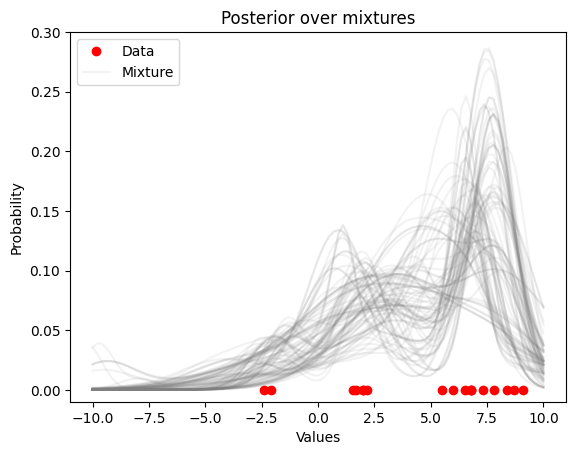

In [8]:
plot_posterior(dataset2, dist)

# Other constructions of the Dirichlet Process

The above implementation uses the stick-breaking construction of the DP. Another construction is the CRP, described using the metaphor of a restaurant with an infinite number of tables, where patrons are more likely to be seated at more populated tables. We compare both constructions below.

Text(0.5, 0, 'Number of clusters')

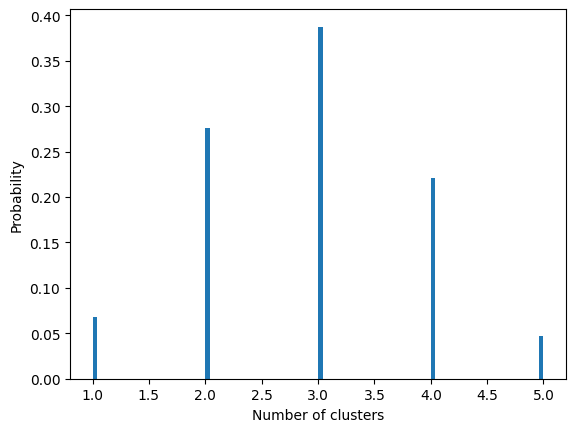

In [9]:
from flippy.distributions.builtin_dists import Categorical

def sample_category(concentration, c=0):
    if flip(break_stick(c, concentration)):
        return c
    return sample_category(concentration, c + 1)

@infer(method="SamplePrior", samples=10_000)
def dp_stick_breaking(n, concentration):
    cs = set()
    for _ in range(n):
        cs |= {sample_category(concentration)}
    return len(cs)

dp_stick_breaking(5, 2).plot()
plt.xlabel('Number of clusters')

Text(0.5, 0, 'Number of clusters')

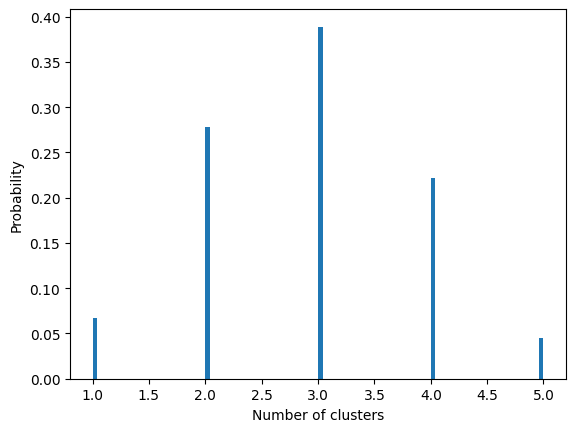

In [10]:
def increment(arr, idx):
    return arr[:idx] + [arr[idx] + 1] + arr[idx+1:]

@infer(method="Enumeration")
def dp_restaurant(n, concentration):
    counts = []
    for _ in range(n):
        c = Categorical(range(len(counts) + 1), weights=counts + [concentration]).sample()
        if c == len(counts): # sampled a new category
            counts += [0]
        counts = increment(counts, c)
    return len(counts)

dp_restaurant(5, 2).plot()
plt.xlabel('Number of clusters')